**hyperparameter-tuning using Bayesian Optimization: bayes_opt or hyperopt.**


Bayesian optimization is more efficient in time and memory capacity for tuning many hyperparameters.

 I will demonstrate the process to tune 2 things of Neural Network: (1) the hyperparameters and (2) the layers.

 Hyperparameter Tuning in Deep Learning
The first hyperparameter to tune is the number of neurons in each hidden layer. In this case, the number of neurons in every layer is set to be the same. It also can be made different. The number of neurons should be adjusted to the solution complexity. The task with a more complex level to predict needs more neurons. The number of neurons range is set to be from 10 to 100.

An activation function is a parameter in each layer. Input data are fed to the input layer, followed by hidden layers, and the final output layer. The output layer contains the output value. The input values moving from a layer to another layer keep changing according to the activation function. The activation function decides how to compute the input values of a layer into output values. The output values of a layer are then passed to the next layer as input values again. The next layer then computes the values into output values for another layer again. There are 9 activation functions to tune in to this demonstration. Each activation function has its own formula (and graph) to compute the input values. It will not be discussed in this article.

The layers of a neural network are compiled and an optimizer is assigned. The optimizer is responsible to change the learning rate and weights of neurons in the neural network to reach the minimum loss function. Optimizer is very important to achieve the possible highest accuracy or minimum loss. There are 7 optimizers to choose from. Each has a different concept behind it.

One of the hyperparameters in the optimizer is the learning rate. We will also tune the learning rate. Learning rate controls the step size for a model to reach the minimum loss function. A higher learning rate makes the model learn faster, but it may miss the minimum loss function and only reach the surrounding of it. A lower learning rate gives a better chance to find a minimum loss function. As a tradeoff lower learning rate needs higher epochs, or more time and memory capacity resources.


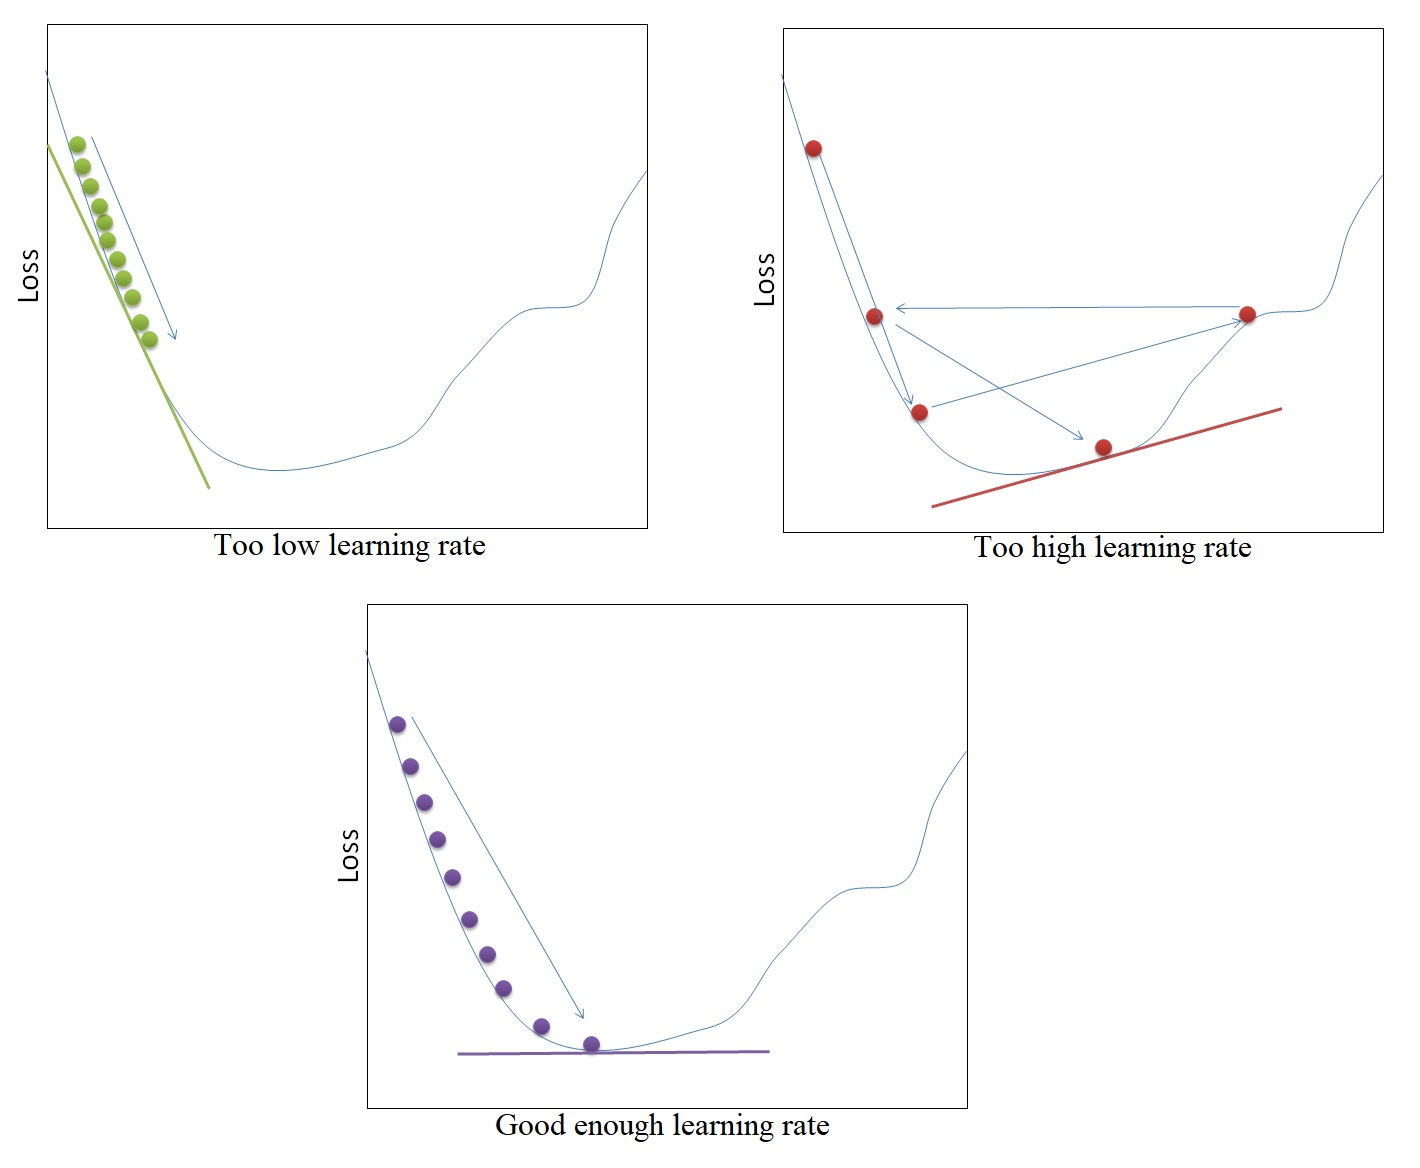

###If the observation size of the training dataset is too large, it will definitely take a longer time to build the model. To make the model learn faster, we can assign batch size so that not all of the training data are given to the model at the same time. Batch size is the number of training data sub-samples for the input. If the training dataset has 77,500 observations and the batch size is 1000, the model will learn 77 times with 1000 training data sub-samples and another last learning from the 500 training data sub-samples. The smaller batch size makes the learning process faster, but the variance of the validation dataset accuracy is higher. A bigger batch size has a slower learning process, but the validation dataset accuracy has a lower variance.

###The number of times a whole dataset is passed through the neural network model is called an epoch. One epoch means that the training dataset is passed forward and backward through the neural network once. A too-small number of epochs results in underfitting because the neural network has not learned much enough. The training dataset needs to pass multiple times or multiple epochs are required. On the other hand, too many epochs will lead to overfitting where the model can predict the data very well, but cannot predict new unseen data well enough. The number of epoch must be tuned to gain the optimal result. This demonstration searches for a suitable number of epochs between 20 to 100.

Below is the code to tune the hyperparameters of a neural network as described above using Bayesian Optimization.

In [1]:
!pip install keras==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.12.0 which is incompatible.


In [2]:
!pip install bayesian-optimization==1.4.1

Reason for being yanked: https://github.com/fmfn/BayesianOptimization/pull/388


In [3]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [4]:
#This code makes accuracy the scorer metric.

# Make scorer accuracy
score_acc = make_scorer(accuracy_score)


In [5]:
#This code loads training and test datasets. It then splits the dataset into another training dataset and validation dataset. The validation dataset is 20% of the total dataset. The dataset is split according to the target variable.
# Load dataset
trainSet = pd.read_csv('train.csv')
# Feature generation: training data
train = trainSet.drop(columns=['Name', 'Ticket', 'Cabin'])
train = train.dropna(axis=0)
train = pd.get_dummies(train)
# train validation split
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=['PassengerId','Survived'], axis=0),
                                                  train['Survived'],
                                                  test_size=0.2, random_state=111,
                                                  stratify=train['Survived'])

In [6]:
#The following code creates the objective function containing the Neural Network model. The function will return returns the score of the cross-validation.

# Create function
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    def nn_cl_fun():
        opt = Adam(lr = learning_rate)
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=10, activation=activation))
        nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [7]:
#The code below sets the range of hyperparameters and run the Bayesian Optimization

# Set paramaters
params_nn ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  epochs   | learni... |  neurons  | optimizer |
-------------------------------------------------------------------------------------------------
171/171 [==============================] - 0s 2ms/step
| 1         | 0.6075    | 5.51      | 335.3     | 54.88     | 0.7716    | 36.58     | 1.044     |
171/171 [==============================] - 0s 2ms/step
| 2         | 0.5947    | 0.2023    | 536.2     | 39.09     | 0.3443    | 99.16     | 1.664     |
171/171 [==============================] - 0s 1ms/step
| 3         | 0.4859    | 0.7307    | 735.7     | 69.7      | 0.2815    | 51.96     | 0.8286    |
171/171 [==============================] - 0s 2ms/step
| 4         | 0.5704    | 0.6656    | 920.6     | 83.52     | 0.8422    | 83.37     | 6.937     |
171/171 [==============================] - 0s 2ms/step
| 5         | 0.7612    | 5.195     | 851.0     | 53.71     | 0.03717   | 50.87     | 0.7373    |
171/171 [==============================

In [8]:
nn_bo

In [9]:
#Here are the best hyperparameters.

params_nn_ = nn_bo.max['params']
print(params_nn)
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
print(round(params_nn_['activation']))
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_

{'neurons': (10, 100), 'activation': (0, 9), 'optimizer': (0, 7), 'learning_rate': (0.01, 1), 'batch_size': (200, 1000), 'epochs': (20, 100)}
5


{'activation': 'selu',
 'batch_size': 373.87633695429145,
 'epochs': 77.53809882694163,
 'learning_rate': 0.04056128946327648,
 'neurons': 47.68371572646683,
 'optimizer': 1.968575834097605}

#In the code above, the neural network is built in line 14 to line 24 of the #Create function starting from the function def nl_cl_fun. The neural network layers architecture is built before performing the cross-validation. This is different from conventional Machine Learning. Other Machine Learning does need to build the architecture like in def nl_cl_fun before performing the cross-validation.

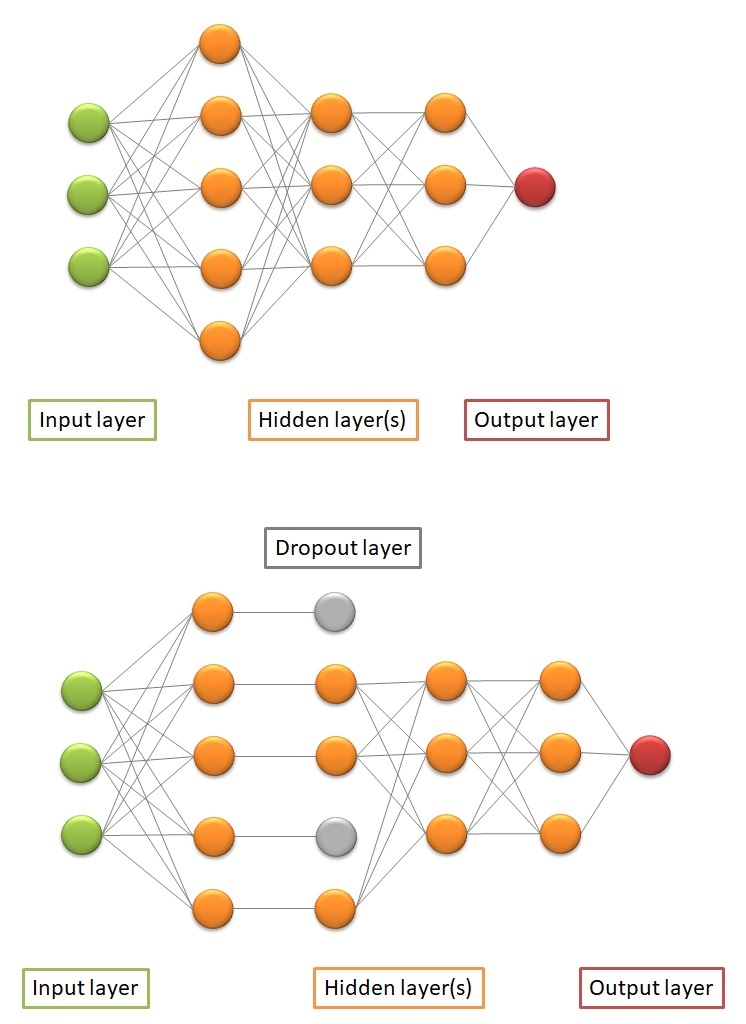

###Tune the Layers
##Layers in Neural Network also determine the result of the prediction model. A smaller number of layers is enough for a simpler problem, but a larger number of layers is needed to build a model for a more complicated problem. The number of layers can be tuned using the “for loop” iteration. This demonstration tune the number of layers two times. Each time, the number of layers is tuned between 1 to 3.

###Inserting regularization layers in a neural network can help **prevent overfitting.** This demonstration tries to tune whether to add regularization layers or not. There are two regularization layers to use here.

#### **Batch normalization** is placed after the first hidden layers. The batch normalization layer normalizes the values passed to it for every batch. This is similar to standard scaler in conventional Machine Learning.

##Another regularization layer is the **Dropout layer.** The dropout layer, as its name suggests, randomly drops a certain number of neurons in a layer. The dropped neurons are not used anymore. The rate of how much percentage of neurons to drop is set in the dropout rate. The following is the code to tune the hyperparameters and layers at the same time.

In [10]:
#The following code creates a function for tuning the Neural Network hyperparameters and layers.

# Create function
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=10, activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization())
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

#The following code searches for the optimum hyperparameters and layers for the Neural Network model.

params_nn2 ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(1,3),       #see layers added
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
171/171 [==============================] - 0s 1ms/step
| 1         | 0.6081    | 5.51      | 335.3     | 0.4361    | 0.2308    | 43.63     | 1.298     | 1.045     | 0.426     | 31.48     | 0.3377    | 6.935     |
171/171 [==============================] - 0s 2ms/step
| 2         | 0.5704    | 2.14      | 265.0     | 0.6696    | 0.1864    | 41.94     | 1.932     | 1.237     | 0.08322   | 91.07     | 0.794     | 5.884     |
171/171 [==============================] - 0s 2ms/step
| 3         | 0.5704    | 7.337     | 992.8     | 0.5773    | 0.2441    | 53.71     | 1.055     | 1.908     | 0.1143    | 83.55     | 0.6977    | 3.957     |
171/171 [==============================] - 0s

In [11]:
#Here are the tuned hyperparameters and layers.

params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

{'activation': 'tanh',
 'batch_size': 284,
 'dropout': 0.15252534628981973,
 'dropout_rate': 0.08205875143738746,
 'epochs': 83,
 'layers1': 2,
 'layers2': 3,
 'learning_rate': 0.4387372674932637,
 'neurons': 17,
 'normalization': 0.010643257301658493,
 'optimizer': <keras.optimizers.legacy.adadelta.Adadelta at 0x79243195fe50>}

##It has 67 neurons for each layer. There is a batch normalization after the first hidden layer, followed by 1 neuron hidden layer. Next, the Dropout layer drops 15% of the neurons before the values are passed to 3 more neuron hidden layers. Finally, the output layer has one neuron containing the probability value. See Figure 4 for the illustration. Now that we have the optimal hyperparameters and layers with the estimated accuracy of 0.7684, let’s fit it into the training dataset. Eventually, we get an accuracy of 0.7681 for the validation dataset.

In [12]:
# Fitting Neural Network
def nn_cl_fun():
    nn = Sequential()
    nn.add(Dense(params_nn_['neurons'], input_dim=10, activation=params_nn_['activation']))
    if params_nn_['normalization'] > 0.5:
        nn.add(BatchNormalization())
    for i in range(params_nn_['layers1']):
        nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    if params_nn_['dropout'] > 0.5:
        nn.add(Dropout(params_nn_['dropout_rate'], seed=123))
    for i in range(params_nn_['layers2']):
        nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(loss='binary_crossentropy', optimizer=params_nn_['optimizer'], metrics=['accuracy'])
    return nn

es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=nn_cl_fun, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'],
                         verbose=0)

nn.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1)

Epoch 1/83
96/96 [==============================] - 1s 6ms/step - loss: 0.6541 - accuracy: 0.6041 - val_loss: 0.6554 - val_accuracy: 0.6229
Epoch 2/83
96/96 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.6686 - val_loss: 0.6688 - val_accuracy: 0.6262
Epoch 3/83
96/96 [==============================] - 0s 3ms/step - loss: 0.5676 - accuracy: 0.7117 - val_loss: 0.5547 - val_accuracy: 0.7141
Epoch 4/83
96/96 [==============================] - 0s 3ms/step - loss: 0.5458 - accuracy: 0.7325 - val_loss: 0.5779 - val_accuracy: 0.7050
Epoch 5/83
96/96 [==============================] - 0s 3ms/step - loss: 0.5272 - accuracy: 0.7468 - val_loss: 0.5796 - val_accuracy: 0.6867
Epoch 6/83
96/96 [==============================] - 0s 3ms/step - loss: 0.5186 - accuracy: 0.7554 - val_loss: 0.5213 - val_accuracy: 0.7541
Epoch 7/83
96/96 [==============================] - 0s 3ms/step - loss: 0.5158 - accuracy: 0.7584 - val_loss: 0.5081 - val_accuracy: 0.7650
Epoch 8/83
96/96 [==

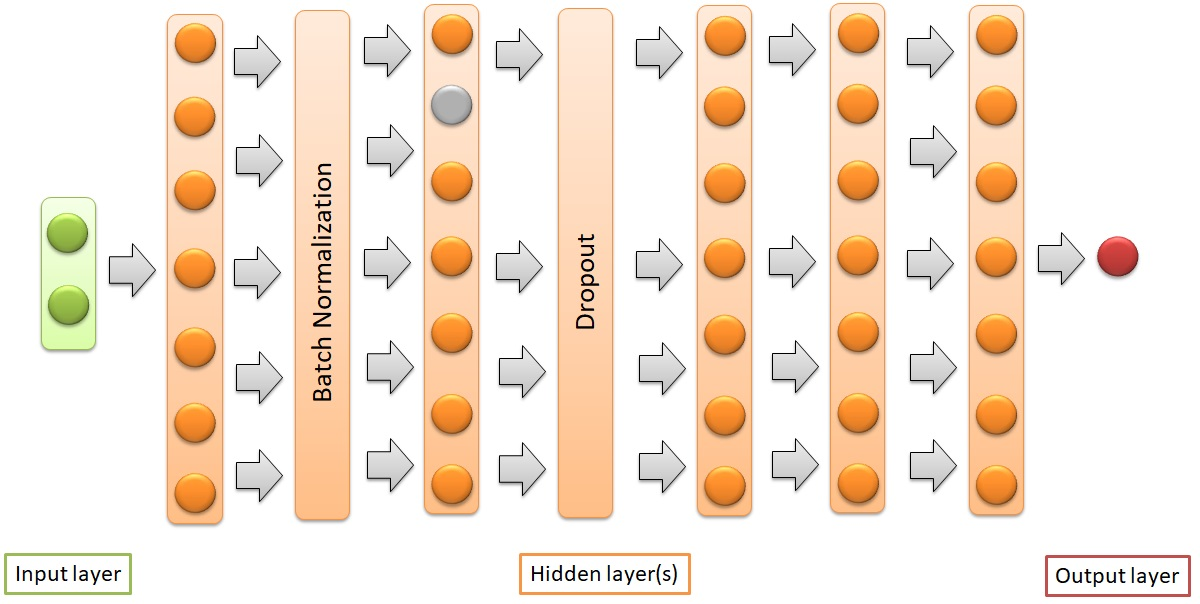

##Q1. What are the hyperparameters of a neural network?
A. Hyperparameters of a neural network are variables that determine the network’s architecture and behavior during training. They include the number of layers, the number of nodes in each layer, the activation functions, learning rate, batch size, regularization parameters, dropout rate, optimizer choice, and weight initialization methods. Tuning these hyperparameters is crucial for optimizing the neural network’s performance.

##Q2. What is Hyperparameter tuning in neural network?
A. Hyperparameter tuning in neural networks refers to the process of finding the optimal combination of hyperparameters to maximize the performance and effectiveness of the network. It involves systematically exploring different values or ranges of hyperparameters, training and evaluating the network for each configuration, and selecting the set of hyperparameters that yield the best performance on a validation set or through cross-validation.